In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [2]:
!wget -nc https://lazyprogrammer.me/course_files/spam.csv


--2022-08-08 11:04:42--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.09s   

2022-08-08 11:04:43 (5.25 MB/s) - ‘spam.csv’ saved [503663/503663]



In [ ]:
!ls

sample_data  spam.csv


In [3]:
df = pd.read_csv('spam.csv',encoding='ISO-8859=1')

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)

In [6]:
df.columns = ['label','data']

In [7]:
df.head()

,label,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:

df['b_label'] = df['label'].map({'ham':0,'spam':1})
Y = df['b_label'].values

In [9]:
Y

array([0, 0, 1, ..., 0, 0, 0])

In [10]:
X_train,X_test,y_train,y_test = train_test_split(df['data'],Y,test_size=0.33)

In [11]:
max_vocab = 20000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)
seq_train = tokenizer.texts_to_sequences(X_train)
seq_test = tokenizer.texts_to_sequences(X_test)

In [12]:
V = len(tokenizer.index_word)

In [13]:
dt_train = pad_sequences(seq_train)
T = dt_train.shape[1]
T

189

In [14]:
dt_test = pad_sequences(seq_test,maxlen=T)
dt_test.shape

(1839, 189)

In [15]:
D = 20
M = 15
i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)
model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [16]:
with tf.device('/device:GPU:0'):
  r = model.fit(dt_train,y_train,epochs=10,validation_data=(dt_test,y_test),steps_per_epoch=len(dt_train))

Epoch 1/10
3733/3733 [==============================] - 39s 9ms/step - loss: 0.1985 - accuracy: 0.9255 - val_loss: 0.0762 - val_accuracy: 0.9842
Epoch 2/10
3733/3733 [==============================] - 31s 8ms/step - loss: 0.0333 - accuracy: 0.9928 - val_loss: 0.0535 - val_accuracy: 0.9864
Epoch 3/10
3733/3733 [==============================] - 33s 9ms/step - loss: 0.0130 - accuracy: 0.9973 - val_loss: 0.0467 - val_accuracy: 0.9869
Epoch 4/10
3733/3733 [==============================] - 31s 8ms/step - loss: 0.0057 - accuracy: 0.9987 - val_loss: 0.0567 - val_accuracy: 0.9853
Epoch 5/10
3733/3733 [==============================] - 31s 8ms/step - loss: 0.0027 - accuracy: 0.9989 - val_loss: 0.0711 - val_accuracy: 0.9842
Epoch 6/10
3733/3733 [==============================] - 31s 8ms/step - loss: 0.0016 - accuracy: 0.9997 - val_loss: 0.0763 - val_accuracy: 0.9831
Epoch 7/10
3733/3733 [==============================] - 32s 9ms/step - loss: 4.3169e-04 - accuracy: 1.0000 - val_loss: 0.0779 - va

In [ ]:
len(dt_train)

3733

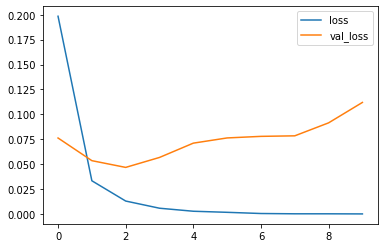

In [17]:
plt.plot(r.history['loss'],label ='loss')
plt.plot(r.history['val_loss'],label ='val_loss')
plt.legend()

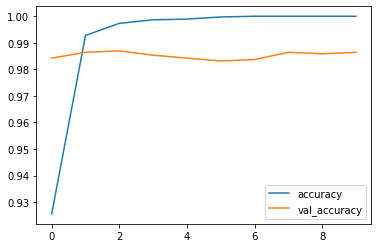

In [18]:
plt.plot(r.history['accuracy'],label ='accuracy')
plt.plot(r.history['val_accuracy'],label ='val_accuracy')
plt.legend()

In [24]:
y_pred = model.predict(dt_test).argmax(axis=1)
miss_idx = np.where(y_pred != y_test)[0]
len(miss_idx)

266

0